<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#코인판-크롤러-프로그램" data-toc-modified-id="코인판-크롤러-프로그램-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>코인판 크롤러 프로그램</a></span><ul class="toc-item"><li><span><a href="#크롤링-프로그램" data-toc-modified-id="크롤링-프로그램-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>크롤링 프로그램</a></span></li></ul></li></ul></div>

# 코인판 크롤러 프로그램

해당 프로그램은 2022년 11월에 제작됐으며, 향후 코인판 홈페이지의 개편이나 보안 강화가 이뤄질 경우, 해당 프로그램이 작동되지 않을 수 있습니다.

In [1]:
#module import 

import time
import json
import urllib
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from konlpy.tag import Okt

okt = Okt()

In [33]:
plt.rcParams["font.family"] = "Hancom MalangMalang"
plt.rcParams['figure.figsize'] = 10,10
sns.set(font="Hancom MalangMalang", rc={"axes.unicode_minus":False}, style='white')

In [3]:
#function

def word_counter(value, key_words):
    for i in value:
        if i not in key_words:
            key_words[i] = 1 #최초 언어
        elif i in key_words:
            key_words[i] += 1 #중복 언어
    return key_words


def tokenizer(text):
    for i in text:
        word = okt.nouns(i) #토큰화
    return text


def counter_to_DataFrame(key_words):
    word_df = pd.DataFrame(key_words.items()) #Data Frame 형성
    word_df.columns = ['단어', '빈도']
    word_df = word_df.sort_values(['빈도'],ascending = False).reset_index(drop = True) #내림차순 정렬
    return word_df


## 크롤링 프로그램
하단의 프로그램을 통해 코인판의 내용을 크롤링 할 수 있습니다

In [4]:
iter = 1000    #몇 페이지까지 크롤링 할 것인지?

In [5]:
key_words = {}
word_lis = []

for i in range(iter):
    url = 'https://coinpan.com/index.php?mid=free&page=' + str(i)
    
    #딜레이 생성
    seed = np.random.randint(100)
    np.random.seed(seed)
    a = np.random.randint(5)
    time.sleep(a)

    #url 호출
    session = requests.session()
    res = session.get(url)
    res.raise_for_status()

    #html 추출
    soup = BeautifulSoup(res.text, 'html.parser')
    a = soup.find_all("td", attrs = {'class':'title'}) #제목이 들어있는 태그의 텍스트 추출
    text = str(a)
    num = len(a)
    words = re.compile('[가-힣]+').findall(text) #한글 제외 전부 제거
    words = words[23:-18] #불용어 제거

    token = tokenizer(words) #토큰화
    word_lis.append(token) #for topic_modeling
    key_words = word_counter(words, key_words) #Counter Dict 형성


In [18]:
df = counter_to_DataFrame(key_words) #Data Frame으로 변환
df #새글, 첨부, 이미지는 불용어 --> 이는 별도로 제거

,단어,빈도
0,새글,19213
1,첨부,8765
2,이미지,4489
3,다,737
4,형들,700
...,...,...
849,차트깨졌내요,2
850,질서있는퇴장바랍니다,2
851,장난감되는거임,1
852,새력,1


In [24]:
df = df[df["단어"].str.len()>=2].drop([0,1,2]) #불용어 제거
df.reset_index(drop=True, inplace=True)

In [26]:
 top_df = df.head(20) #상위 20개 단어 추출

<AxesSubplot:xlabel='빈도', ylabel='단어'>

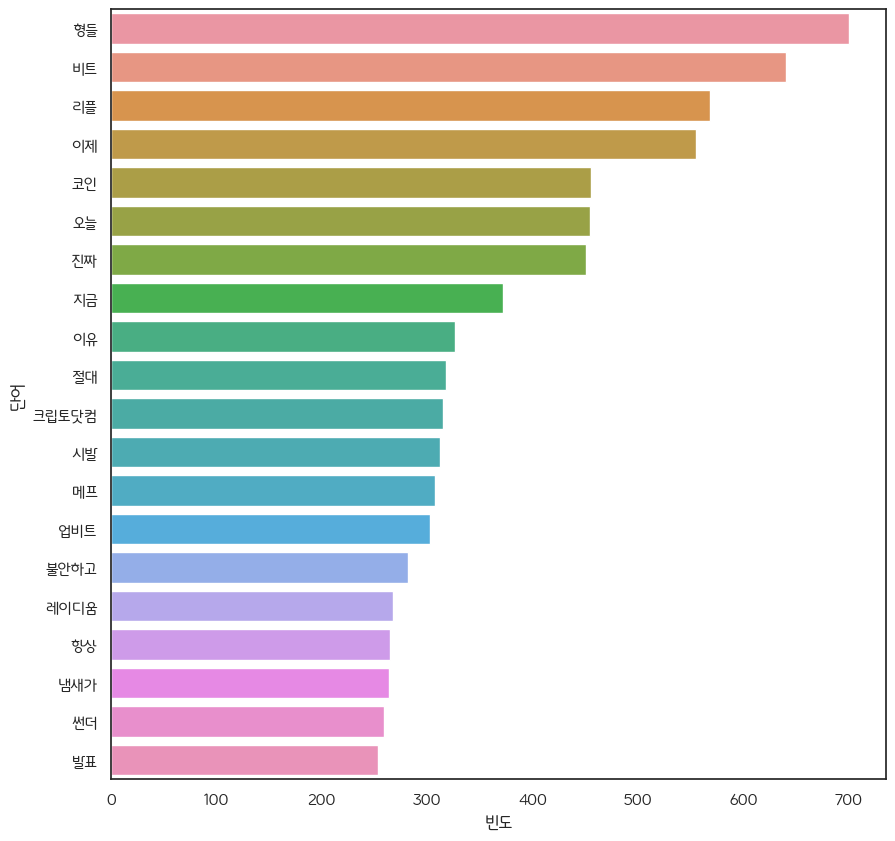

In [34]:
sns.barplot(data = top_df, x = '빈도', y = '단어')

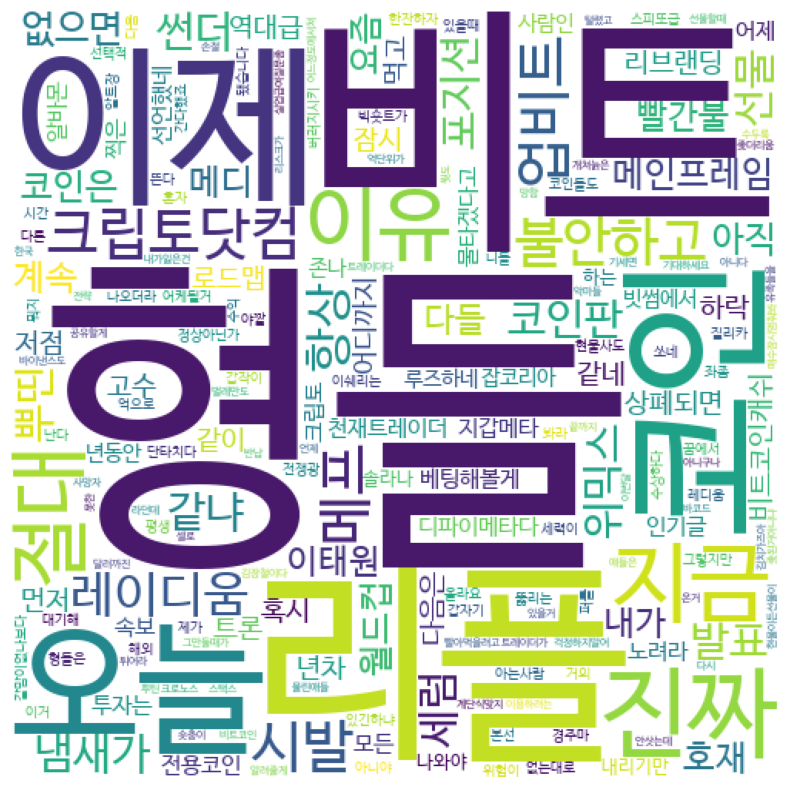

In [28]:
#WordCloud 형성
wc = WordCloud(font_path = 'C:\\Users\\cjsso\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf', #폰트 위치(사용자에 맞게 설정)
    width = 500,
    height = 500,
    background_color='white').generate_from_frequencies(df.set_index('단어').to_dict()['빈도'])


plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [29]:
for lis in word_lis:
    while '새글' in lis:
        lis.remove('새글')
    while '이미지' in lis:
        lis.remove('이미지')
    while '첨부' in lis:
        lis.remove('첨부')

In [30]:
from gensim import corpora
coin_dict = corpora.Dictionary(word_lis)
corpus = [coin_dict.doc2bow(text) for text in word_lis]

In [31]:
import gensim

perplexity = []
for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    perplexity.append(ldamodel.log_perplexity(corpus))

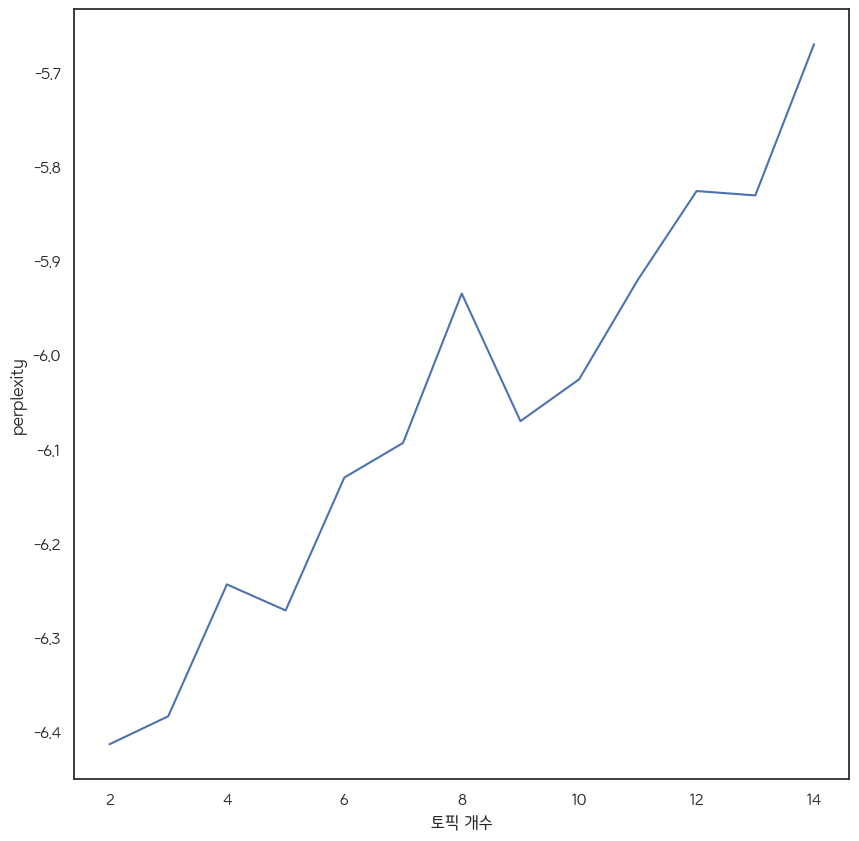

In [35]:
x = range(2,15)
plt.plot(x,perplexity)
plt.xlabel("토픽 개수")
plt.ylabel("perplexity")
plt.show()

In [36]:
from gensim.models import CoherenceModel

coherence = []
for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    coherence_mo_lda = CoherenceModel(model = ldamodel, texts = word_lis, dictionary = coin_dict, topn=10) 
    coherence_lda = coherence_mo_lda.get_coherence()
    coherence.append(coherence_lda)

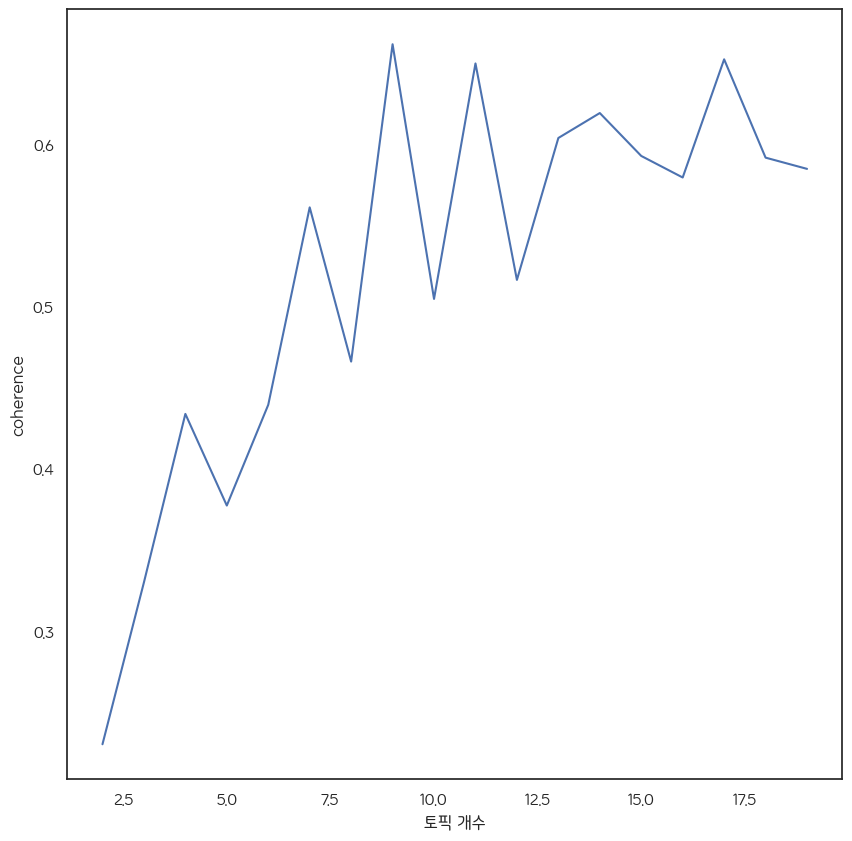

In [37]:
x = range(2,20)
plt.plot(x,coherence)
plt.xlabel("토픽 개수")
plt.ylabel("coherence")
plt.show()

In [38]:
NUM_TOPICS = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=coin_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.019*"세럼" + 0.018*"형들" + 0.016*"진짜" + 0.014*"메프" + 0.012*"헤데라"')
(1, '0.029*"비트" + 0.013*"메인프레임" + 0.013*"진짜" + 0.013*"혹시" + 0.012*"뽀글이"')
(2, '0.017*"같이" + 0.017*"다" + 0.011*"크립토닷컴" + 0.011*"비트" + 0.009*"눈"')
(3, '0.026*"비트" + 0.018*"코인" + 0.016*"다" + 0.015*"절대" + 0.014*"내가"')
(4, '0.023*"다" + 0.017*"오늘" + 0.016*"절대" + 0.013*"송금시" + 0.013*"바이낸스"')
(5, '0.013*"장" + 0.012*"투자는" + 0.012*"모든" + 0.012*"루즈하네" + 0.012*"존나"')
(6, '0.035*"이제" + 0.019*"지금" + 0.018*"이" + 0.016*"언제" + 0.015*"잦된것같네"')
(7, '0.017*"진짜" + 0.016*"메디" + 0.016*"식" + 0.011*"다" + 0.010*"시발"')
(8, '0.025*"냄새가" + 0.024*"불안하고" + 0.022*"리플" + 0.021*"포지션" + 0.021*"코인"')


In [39]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, coin_dict)
pyLDAvis.display(vis)

C:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [44]:
pyLDAvis.save_html(vis, 'coinpan_LDA.html') #LDAvis save